# [MS65] Tutorials for Students: 
# An Introduction to Sampling with Measure Transport

This notebook is a companion to the presentation given in MS65 at SIAM annual in 2022.  The source code can be found at:

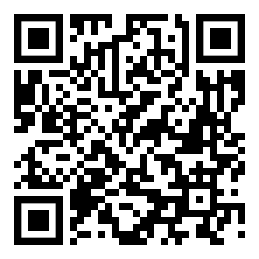

[https://github.com/MeasureTransport/SIAMannual22](https://github.com/MeasureTransport/SIAMannual22)



 It is composed of four examples, all of which demonstrate different uses of monotone function parameterizations. 

Contents:
1. Monotone adaptations of polynomial expansion with rectifier functions.
2. Use of monotone transformations for density estimation and generative modeling, i.e., "maps from samples".
3. Variational inference using monotone transformations, i.e., "maps from densities".
4. Transport maps for likelihood-free inference.

These examples make use of the fast monotone implementations provided by the [Monotone Parameterization Toolkit (MParT)](https://github.com/MeasureTransport/MParT). 

The recommended way of running this notebook is to [use binder](https://mybinder.org/v2/gh/MeasureTransport/SIAMannual22/HEAD), but it is also possible to install MParT locally.  

# Part 0: Imports
First, import MParT and other packages used in this notebook. Note that it is possible to specify the number of threads used by MParT by setting the `KOKKOS_NUM_THREADS` environment variable before importing MParT.

In [42]:
from mpart import *
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import scipy.stats
import copy
from scipy.stats import multivariate_normal
import time

print('Kokkos is using', Concurrency(), 'threads')

Kokkos is using 8 threads


## Part 1: Monotone adaptations of polynomial expansions

In order to parametrized the class of monotone functions we use the concept of a rectifier (see [[Baptista et al., 2022]](https://arxiv.org/pdf/2009.10303.pdf)). The objective of the rectifier is to transform any multivariate functions to a monotone function with respect to the last variable. The rectifier $R(f)$ of a function $f:\mathbb{R}^d \rightarrow \mathbb{R}^d$ is defined as follow:
\begin{equation}
R(f)(x_{1:d}) = f(x_1,...,x_{d-1},0) + \int_0^{x_d} g\left(\partial_{x_d} f(x_1,...,x_{d-1},t\right) \text{d}t
\end{equation}
where $g$ is a real positive function, often a positive-valued bijection.  For example,
\begin{equation}
g(\xi) = \frac{\log(1+2^\xi)}{\log(2)}.
\end{equation}

MParT parameterizes the base function $f:\mathbb{R}^d \rightarrow \mathbb{R}^d$ with a multivariate polynomial expansion, which takes the form 

$$
f(x_{1:d}) = \sum_{\mathbf{\alpha} \in \mathcal{A}} w_{\mathbf{\alpha}} \Phi_{\mathbf{\alpha}}(x_{1:d}),
$$

where $\mathbf{\alpha}$ are multiindices in the set $\mathcal{A}$ that define the terms in the expansion (e.g., the order of each polynomial term), and $\Phi_{\mathbf{\alpha}}(x_{1:d})$ are multivariate basis functions defined through the tensor product of one-dimensional polynomials:

$$
\Phi_i(x_{1:d}) = \prod_{i=1}^d \phi_{\alpha_i}(x_i)
$$

A multiindex $\mathbf{\alpha}=[\alpha_1,\alpha_2,\ldots,\alpha_d]$ is just a list containing the degree of each scalar polynomial $\phi_{\alpha_i}(x_i)$.   Here we will use 1d Hermite polynomials, which are orthogonal with respect to a Gaussian weighting function.  The first few probabilist Hermite polynomials are given by 

$$
\begin{aligned}
\phi_0(x) &= 1\\
\phi_1(x) &= x \\
\phi_2(x) &= x^2-1 \\
\phi_3(x) &= x^3-x \\
\phi_4(x) &= x^4-6x^2+3.
\end{aligned}
$$

The multiindex sets $\mathcal{A}$ defines which multivariate polynomials are included in the expansion.  A common choice is to choose the set to based on the total order of the multi-index, which is simply the sum of the multi-index components.  For example, the set of multiindices with total order $\leq p$ is given by 

$$
\mathcal{A}_{tot}(p) =  \left\{ \mathbf{\alpha}\in \mathbb{N}^d \, : \, \sum_{i=1}^d \alpha_i \leq p \right\}.
$$ 

This type of total-order limited set is what we use in this example.  More parsimonius, or adaptively constructed, sets are often more useful as the dimension $d$ grows however.

##### Set options defining $f(x)$

In [43]:
in_dim = 1 # same as "d" in discussion above
out_dim = 1 # The dimension of f(x_{1:d}), which must be less than or equal to d

total_order = 5 # The total order "p" used to define the multindex set

##### Create a rectified polynomial expansion with random coefficients

In [44]:

# Create the rectified expansion
opts = MapOptions()
opts.basisType = BasisTypes.ProbabilistHermite

rf = CreateTriangular(in_dim, out_dim, total_order, opts)
coeffs = 0.5*np.random.randn(rf.numCoeffs)
rf.SetCoeffs(coeffs) 

# Extract the underlying non-monotone expansion
f = rf.GetComponent(0).GetBaseFunction()
f.SetCoeffs(coeffs)

##### Plot the functions

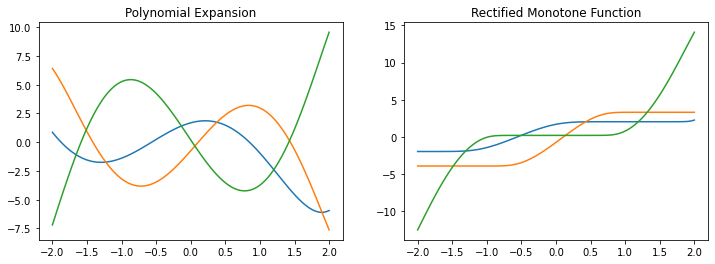

In [45]:
nplot = 100
num_samps = 3
x = np.linspace(-2,2,nplot).reshape(1,-1)

fig,ax = plt.subplots(1,2, figsize=(12,4))

# Plot multiple times with different random coefficients
for samp_ind in range(num_samps):
    Sy = rf.Evaluate(x)
    y = f.Evaluate(x)

    ax[0].plot(x.flatten(),y.flatten())
    ax[0].set_title('Polynomial Expansion')

    ax[1].plot(x.flatten(),Sy.flatten())
    ax[1].set_title('Rectified Monotone Function')

    coeffs = 0.5*np.random.randn(rf.numCoeffs)
    rf.SetCoeffs(coeffs) 
    f.SetCoeffs(coeffs)

plt.show()

## Isotonic Regression 

One direct use of the monotonicity property given by the above rectified parametrization is to model monotone functions from noisy data. This is called isotonic regression and can be solved in our setting by minimizing the objective function

$$
J(\mathbf{w})= \frac{1}{2} \sum_{i=1}^N \left(S(x^i;\mathbf{w}) - y^i \right)^2,
$$

where $S$ is a monotone 1D map with parameters (polynomial coefficients) $\mathbf{w}$ and $y^i$ are noisy observations.   To solve for the map parameters that minimize this objective we will use a gradient-based optimizer.  We therefore need the gradient of the objective with respect to the map paramters.  This is given by

$$
\nabla_\mathbf{w} J(\mathbf{w})= \sum_{i=1}^N \left(S(x^i;\mathbf{w}) - y^i \right)^T\left[\nabla_\mathbf{w}S(x^i;\mathbf{w})\right]
$$

The implementation of `S(x)` we're using from MParT, provides tools for both evaluating the map to compute  $S(x^i;\mathbf{w})$ but also evaluating computing the action of  $\left[\nabla_\mathbf{w}S(x^i;\mathbf{w})\right]^T$ on a vector, which is useful for computing the gradient.   Below, these features are leveraged when defining an objective function that we then minimize with the BFGS optimizer implemented in `scipy.minimize`.


##### Generate synthetic data to define the regression problem
Here we adapt an isotonic regression example from [scikit-learn](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_isotonic_regression.html#sphx-glr-auto-examples-miscellaneous-plot-isotonic-regression-py).   The following cells generates the observations data $y^i$ used in the objective function above.   

Notice that the "noise" here is not Gaussian -- it is uniformly randomly drawn integers.  The least squares objective function may therefore not be the best choice, but we stick with the integer noise to enable comparisons with scikit-learn.

In [46]:
n = 100
x = np.arange(n)
x = x.reshape(1,n)
y = np.random.randint(-50, 50, size=(1,n)) + 50. * np.log1p(x) # adapted from scikit-learn example
ytruth = 50. * np.log1p(x)


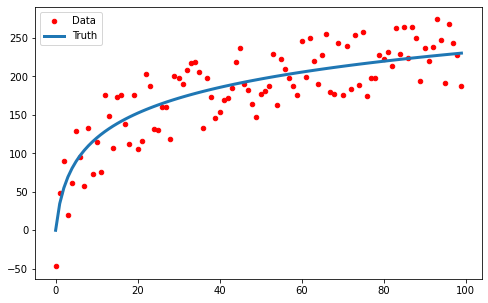

In [47]:
plt.figure(figsize=(8,5))
plt.plot(x.flatten(), y.flatten(), '.r', markersize=9,label='Data')
plt.plot(x.flatten(), ytruth.flatten(),label='Truth',linewidth=3)
plt.legend()
plt.show()

##### Define the parameterization

In [48]:
map_order = 4
tri_map = CreateTriangular(1,1, map_order, MapOptions())
coeffs = np.zeros(tri_map.numCoeffs)
tri_map.SetCoeffs(coeffs) #Initial value of coefficient is 0

##### Regression objective:

In [49]:
def objective(coeffs, monotoneMap, x, y_measured):
    monotoneMap.SetCoeffs(coeffs)

    # Evaluate the map
    map_of_x = monotoneMap.Evaluate(x)
    
    # return the objective function
    return 0.5*np.sum((map_of_x - y_measured)**2)

def grad_objective(coeffs, monotoneMap, x, y_measured):
    monotoneMap.SetCoeffs(coeffs)

    # Evaluate the map
    map_of_x = monotoneMap.Evaluate(x)

    # Could the gradient
    sensi = (map_of_x-y_measured)
    grad_map = tri_map.CoeffGrad(x, sensi) 

    return np.sum(grad_map,1)

##### Optimization

In [50]:
x_norm = np.linspace(-2,2,n)
x_norm = x_norm.reshape(1,n)

options={'gtol': 1e-4, 'disp': True}

res = scipy.optimize.minimize(objective, 
                              coeffs, 
                              args=(tri_map,x_norm,y), 
                              jac=grad_objective, 
                              method='BFGS', 
                              options=options)

Optimization terminated successfully.
         Current function value: 46140.034323
         Iterations: 40
         Function evaluations: 49
         Gradient evaluations: 49


### Plot map approximation

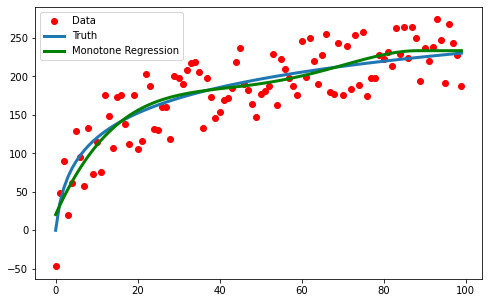

In [51]:
y_map = tri_map.Evaluate(x_norm)

plt.figure(figsize=(8,5))
plt.plot(x.flatten(), y.flatten(), '.r', markersize=12,label='Data')
plt.plot(x.flatten(), ytruth.flatten(),linewidth=3, label='Truth')
plt.plot(x.flatten(), y_map.flatten(),'-g',linewidth=3, label='Monotone Regression')

plt.legend()
plt.show()

Compared to [classical isotonic regression techniques](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_isotonic_regression.html#sphx-glr-auto-examples-miscellaneous-plot-isotonic-regression-py), the monotone parameterization used here allows for a continuously differentiable solution.

## Part 2: Building a Transport Map from Samples

##### Map-Induced Probability Distributions
Through the rectifying step described above, the function $S(\mathbf{x}; \mathbf{w})$ is guaranteed to be invertible and have a positive definite Jacobian for any parameters $w$.  Combined with a probability density $\eta(\mathbf{r})$, we can therefore define a density $\tilde{\pi}_w(x)$ induced by transforming $r$ with the inverse map $S^{-1}(\mathbf{r})$.   More precisely, the change of random variable formula gives 

$$
\tilde{\pi}_{\mathbf{w}}(\mathbf{x}) = \eta(S(\mathbf{x}; \mathbf{w}))\left| \det\nabla S(\mathbf{x}; \mathbf{w})\right|,
$$ 

where $\det\nabla S$ is the determinant of the map Jacobian at the point $\mathbf{x}$.   We refer to $\tilde{\pi}_{\mathbf{w}}(\mathbf{x})$ as the *map-induced* density or *pullback distribution* and will commonly interchange notation for densities and measures to use the notation $\tilde{\pi} = S^{\sharp} \eta$.

 Just like we looked at the functions $S(\mathbf{x};\mathbf{w})$ with random coefficients above, we can now look at random map-induced densities.   Below we create a random two-dimensional triangular map and look at the resulting density when $\eta(\mathbf{r})$ is standard normal.

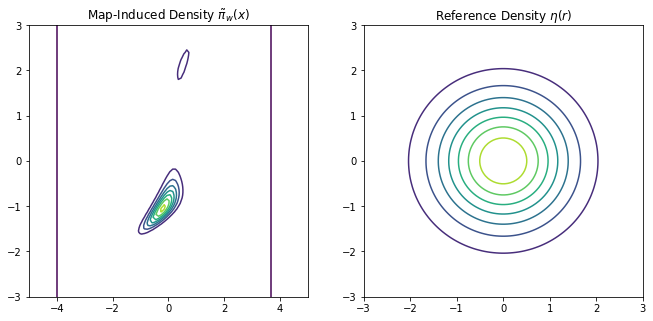

In [52]:
def pullback_pdf(tri_map,rho,x):
    r = tri_map.Evaluate(x)
    log_pdf = rho.logpdf(r.T)+tri_map.LogDeterminant(x)
    return np.exp(log_pdf)


map_order = 3
dim = 2
S = CreateTriangular(dim,dim, map_order, MapOptions())
S.SetCoeffs( np.random.randn(S.numCoeffs))

rho = scipy.stats.multivariate_normal(np.zeros(dim),np.eye(dim))

# Create x and are points on a grid to enable plotting with matplotlib
nplot = 100
r1,r2 = np.meshgrid(np.linspace(-3,3,nplot), np.linspace(-3,3,nplot))
r = np.vstack([r1.reshape(1,-1), r2.reshape(1,-1)])
x1,x2 = np.meshgrid(np.linspace(-5,5,nplot), np.linspace(-3,3,nplot))
x = np.vstack([x1.reshape(1,-1), x2.reshape(1,-1)])

ref_dens = rho.pdf(r.T).reshape(nplot,nplot)
map_dens = pullback_pdf(S, rho, x).reshape(nplot,nplot)

fig, axs = plt.subplots(ncols=2, figsize=(11,5))

axs[0].contour(x1,x2,map_dens)
axs[0].set_title('Map-Induced Density $\\tilde{\pi}_w(x)$')

axs[1].contour(r1,r2,ref_dens)
axs[1].set_title('Reference Density $\eta(r)$')

plt.show()

### Optimizing the map parameters

In part 1, we used the our ability to parameterize monotone functions to solve a 1d isotonic regression problem by solving a nonlinear least squares problems for the map parameters.   Here we do something similar but for density estimation.  The goal is to optimize the map parameters so that the map-induced density "matches" a collection of samples  $\mathbf{x}^i, i\in\{1,...,N\}$ from some unknown distribution $\pi(\mathbf{x})$.   

##### Generate training data

So see how this is done, let's first generate samples from a highly non-Gaussian spiral-like distribution. 

In [53]:
def sample_spiral_distribution(size):
    
    # First draw some rotation samples from a beta distribution, then scale 
    # them to the range between -pi and +2pi
    seeds = scipy.stats.beta.rvs(
        a       = 7,
        b       = 3,
        size    = size)*2*np.pi-np.pi

    # Create a local copy of the rotations
    seeds_orig = copy.copy(seeds)

    # Re-normalize the rotations, then scale them to the range between [-3,+3]
    vals    = (seeds+np.pi)/(3*np.pi)*6-3

    # Plot the rotation samples on a straight spiral
    X       = np.column_stack((
        np.cos(seeds)[:,np.newaxis],
        np.sin(seeds)[:,np.newaxis]))*((1+seeds+np.pi)/(3*np.pi)*3)[:,np.newaxis]

    # Offset each sample along the spiral's normal vector by scaled Gaussian 
    # noise
    X   += np.column_stack([
        np.cos(seeds_orig),
        np.sin(seeds_orig)])*(scipy.stats.norm.rvs(size=size)*scipy.stats.norm.pdf(vals))[:,np.newaxis]
        
    return X/2

Generate and plot training data $\mathbf{x}^i, i\in\{1,...,N\}$:

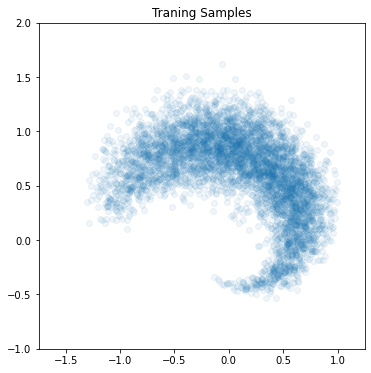

In [54]:
# Training ensemble size
N = 5000

# Draw that many samples
Xtrain = sample_spiral_distribution(N)
Xtrain = Xtrain.transpose()

colors = np.arctan2(Xtrain[1,:],Xtrain[0,:])

fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(Xtrain[0,:],Xtrain[1,:],alpha=0.07, label='Target samples')
ax.set_aspect('equal', 'box')
plt.xlim([-1.75, 1.25])
plt.ylim([-1, 2])
plt.title('Traning Samples')

plt.show()

##### Defining objective function and its gradient

Instead of the least squares objective used above, to match the map induced density $\tilde{\pi}_{\mathbf{w}}(\mathbf{x})$ with the samples, we can maximize the likelihood of observing the samples, which is simply 
$$
\prod_{i=1}^N \tilde{\pi}_w(\mathbf{x}^i).
$$

Numericall, it is typically easier to work with the log-likelihood instead and we will therefore maximize the log likelihood to find the parameters $w$:

$$
w^\ast = \underset{\mathbf{w}}{\operatorname{argmax}} \sum_{i=1}^N \log \tilde{\pi}_{\mathbf{w}}(\mathbf{x}^i).
$$

Importantly, our use of triangular maps and a standard normal reference density allows us to expand this objective into two independent problems: one for the parameters $w_1$ defining the first component $S_1(x_1; w_1)$ of the map, and one for the parameters defining the second component $S_2(x_{1:2}; w_2)$. 
In general, for map component $k$, the objective function is given by 

$$
J_k(\mathbf{w}_k) = - \frac{1}{N}\sum_{i=1}^N \left( \log\eta\left(S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)\right) + \log \frac{\partial S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)}{\partial x_k}\right)
$$

and the resulting optimization problem is 

$$
\mathbf{w}_k^\ast = \underset{\mathbf{w}_k}{\operatorname{argmin}} J_k(\mathbf{w}_k).
$$

In order to use efficient gradient-based minimizer we need to define both the objective and its gradient.  The gradient is given by

$$
\nabla_{\mathbf{w}_k}J_k(\mathbf{w}_k) = - \frac{1}{N}\sum_{i=1}^N \left(\left[\nabla_{\mathbf{w}_k}S_k
(\mathbf{x}_{1:k}^i;\mathbf{w}_k)\right]^T \nabla_\mathbf{r}\log \eta \left(S_k
(\mathbf{x}_{1:k}^i;\mathbf{w}_k)\right) - \frac{\partial \nabla_{\mathbf{w}_k}S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)}{\partial x_k} \left[\frac{\partial S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)}{\partial x_k}\right]^{-1}\right),
$$

where $\nabla_{\mathbf{w}_k}S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)$ is the Jacobian of the map output with respect to the map parameters and $\nabla_\mathbf{r}\log \eta \left(S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)\right)$ is the gradient of the reference log-density evaluated at the map output.  Note that for a standard normal reference density, this expression simplifies to $\nabla_\mathbf{r}\log \eta \left(S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)\right) = -S_k(\mathbf{x}_{1:k}^i;\mathbf{w}_k)$.

### Minimizing objectives

In [55]:
# Negative log likelihood objective

rho1 = multivariate_normal(np.zeros(1),np.eye(1))

def obj(coeffs, tri_map,x):
    """ Evaluates the log-likelihood of the samples using the map-induced density. """
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)

    # Compute the map-induced density at each point 
    map_of_x = tri_map.Evaluate(x)
    rho_of_map_of_x = rho1.logpdf(map_of_x.T)
    log_det = tri_map.LogDeterminant(x)

    # Return the negative log-likelihood of the entire dataset
    return -np.sum(rho_of_map_of_x + log_det)/num_points
    
def grad_obj(coeffs, tri_map, x):
    """ Returns the gradient of the log-likelihood objective wrt the map parameters. """
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)

    # Evaluate the map
    map_of_x = tri_map.Evaluate(x)

    # Now compute the inner product of the map jacobian (\nabla_w S) and the gradient (which is just -S(x) here)
    grad_rho_of_map_of_x = -tri_map.CoeffGrad(x, map_of_x)

    # Get the gradient of the log determinant with respect to the map coefficients
    grad_log_det = tri_map.LogDeterminantCoeffGrad(x)
    
    return -np.sum(grad_rho_of_map_of_x + grad_log_det, 1)/num_points

We're now ready to create a map and solve for the optimal coefficient.  We will choose the paramatrization of each map components by setting the maximum order of polynomials used in the parametrization. We then use the [BFGS solver](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) to find polynomials/map coefficients.


##### Find $S_1(\mathbf{x}_1,\mathbf{w}_1)$

In [56]:
total_order1 = 7

# Create multi-index set:
fixed_mset1 = FixedMultiIndexSet(1,total_order1)

# Set MapOptions and make map
opts = MapOptions()

S1 = CreateComponent(fixed_mset1,opts)

Xtrain1 = Xtrain[0,:].reshape(1,N) #use first coordinate samples only

options={'gtol': 1e-4, 'disp': True}
res1 = scipy.optimize.minimize(obj, S1.CoeffMap(), args=(S1, Xtrain1), jac=grad_obj, method='BFGS', options=options)

/Users/mparno/opt/anaconda3/envs/mpart/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


         Current function value: 0.645850
         Iterations: 22
         Function evaluations: 91
         Gradient evaluations: 80


##### Find $S_2(\mathbf{x}_{1:2},\mathbf{w}_2)$

In [57]:
total_order2 = 7

# Create multi-index set:
fixed_mset2 = FixedMultiIndexSet(2,total_order2)

S2 = CreateComponent(fixed_mset2,opts)

Xtrain2 = Xtrain #use both coordinates samples

options={'gtol': 1e-3, 'disp': True}
res2 = scipy.optimize.minimize(obj, S2.CoeffMap(), args=(S2, Xtrain2), jac=grad_obj, method='BFGS', options=options)

/Users/mparno/opt/anaconda3/envs/mpart/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Optimization terminated successfully.
         Current function value: 0.050443
         Iterations: 148
         Function evaluations: 155
         Gradient evaluations: 152


Once the map coefficients are found we can assess the quality of the map approximation by looking at the "pushed" samples $\mathbf{z}^i=S(\mathbf{x}^i)$. If the map approximation is good, the distribution of the $\mathbf{z}^i$ should be close to a standard normal Gaussian.



### Accuracy check

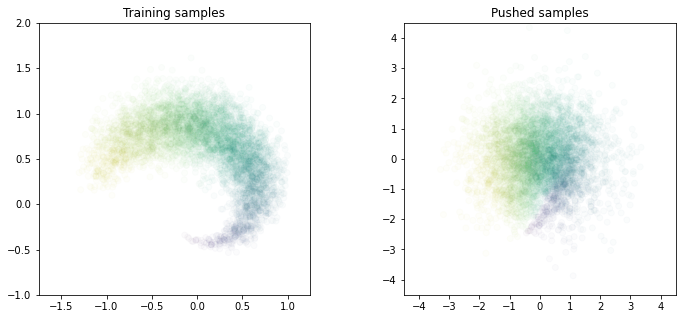

In [58]:
#Gather components in a Triangular Map object:
S = TriangularMap((S1,S2)) 
S.SetCoeffs(np.concatenate((S1.CoeffMap(),S2.CoeffMap())))

#Pushed samples should look like Gaussian samples:
Xpushed = S.Evaluate(Xtrain)

#Plot
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(Xtrain[0],Xtrain[1], c=colors, alpha=0.02, label='Training samples')
ax[0].set_title('Training samples')
ax[0].set_aspect('equal','box')
ax[0].set_xlim((-1.75, 1.25))
ax[0].set_ylim((-1, 2))
ax[1].scatter(Xpushed[0],Xpushed[1], c=colors, alpha=0.02, label='Pushed samples')

ax[1].set_title('Pushed samples')
ax[1].set_aspect('equal', 'box')
ax[1].set_xlim((-4.5, 4.5))
ax[1].set_ylim((-4.5, 4.5))
plt.show()

##### Generative modeling:

With an accurate transport map, we are now able to generate new samples from the map-induced density $\tilde{\pi}_{w^\ast}(\mathbf{x})$ that will resemble the samples in the training data. 


In [59]:
#Draw new samples from the learned distribution:
Znew = np.random.randn(2,5000)

colors_new = np.arctan2(Znew[1,:],Znew[0,:])
Xnew = S.Inverse(Znew,Znew)

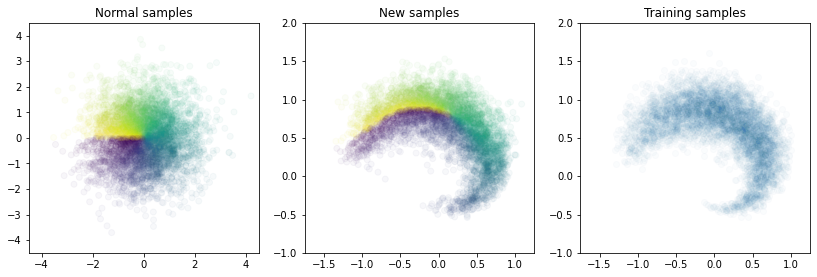

In [60]:
#Plot
fig,ax = plt.subplots(1,3,figsize=(14,6))

ax[0].scatter(Znew[0,:],Znew[1,:], c=colors_new, alpha=0.04, label='Normal samples')
ax[0].set_title('Normal samples')
ax[0].set_aspect('equal', 'box')
ax[0].set_xlim((-4.5, 4.5))
ax[0].set_ylim((-4.5, 4.5))

ax[1].scatter(Xnew[0,:],Xnew[1,:], c=colors_new, alpha=0.04, label='New samples')
ax[1].set_title('New samples')
ax[1].set_aspect('equal', 'box')
ax[1].set_xlim((-1.75, 1.25))
ax[1].set_ylim((-1, 2))

ax[2].scatter(Xtrain[0,:],Xtrain[1,:], alpha=0.02, label='Target samples')
ax[2].set_title('Training samples')
ax[2].set_aspect('equal', 'box')
ax[2].set_xlim((-1.75, 1.25))
ax[2].set_ylim((-1, 2))

plt.show()

##### Density estimation:

We can also evaluate the map-induced density directly.

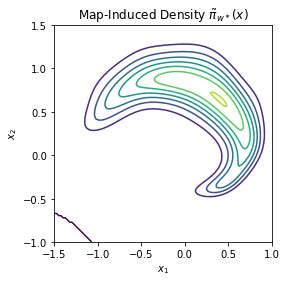

In [61]:
Ngrid = 100
x = np.linspace(-1.5, 1., Ngrid)
y = np.linspace(-1, 1.5, Ngrid)
X, Y = np.meshgrid(x, y)
XY = np.vstack((X.flatten(),Y.flatten()))

rho = multivariate_normal(np.zeros(2),np.eye(2))

Z = pullback_pdf(S,rho,XY)
Z = Z.reshape(Ngrid,Ngrid)

fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.set_aspect('equal', 'box')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title("Map-Induced Density $\\tilde{\pi}_{w^\\ast}(x)$")
plt.show()

## Part 3: Characterizing Bayesian Posterior Densities

In part 2 we showed that a monotone map can be combined with a reference density to define a family of map-induced densities $\tilde{\pi}_{\mathbf{w}}(\mathbf{x})$ that are parameterized by the map coefficients.   Previously, we found the map parameters by maximizing the log likelihood of existing samples.    

Another way construct a transport map is from an unnormalized density. One situation where we know the probality density function up to a normalization constant is when modeling inverse problems with Bayesian inference.

For an inverse problem, the objective is to characterize the value of some parameters $\boldsymbol{\theta}$ of a given system, knowing some the value of some noisy observations $\mathbf{y}$.

With Bayesian inference, the characterization of parameters $\boldsymbol{\theta}$ is done via a *posterior* density $\pi(\boldsymbol{\theta}|\mathbf{y})$. This density characterizes the distribution of the parameters knowing the value of the observations.

Using Bayes' rule, the posterior can decomposed into the product of two probability densities:

1.   The prior density $\pi(\boldsymbol{\theta})$ which is used to enforce any *a priori* knowledge about the parameters.
2.   The likelihood function $\pi(\mathbf{y}|\boldsymbol{\theta})$. This quantity can be seen as a function of $\boldsymbol{\theta}$ and gives the likelihood that the considered system produced the observation $\mathbf{y}$ for a fixed value of $\boldsymbol{\theta}$. When the model that describes the system is known in closed form, the likelihood function is also knwon in closed form.

Hence, the posterior density reads:

$$
\pi(\boldsymbol{\theta}|\mathbf{y}) = \frac{1}{c} \pi(\mathbf{y}|\boldsymbol{\theta}) \pi(\boldsymbol{\theta})
$$

where $c = \int \pi(\mathbf{y}|\boldsymbol{\theta}) \pi(\boldsymbol{\theta}) d\theta$ is an normalizing constant that ensures that the product of the two quantities is a proper density.  Typically, the integral in this definition cannot be evaluated and $c$ is assumed to be unknown.

As in Parts 1 and 2 above, we will accomplish this by defining an objective function that measures the difference between $\pi(\boldsymbol{\theta}|\mathbf{y})$ and the map-induced density $\tilde{\pi}_{\mathbf{w}}(\mathbf{x})$ and then find the map parameters $\mathbf{w}$ that minimize this objective function.  Here, the objective function will be the KL divergence between the map-induced density $\tilde{\pi}_{\mathbf{w}}(\mathbf{x})$ and the posterior density $\pi(\boldsymbol{\theta}|\mathbf{y})$.  Some details are provided below but interested readers should consult [[Marzouk et al., 2016]](https://arxiv.org/pdf/1602.05023.pdf) or [[Moselhy and Marzouk, 2012]](https://arxiv.org/pdf/1109.1516.pdf).

##### Problem description

Knowing the closed form of unnormalized posterior $\bar{\pi}(\boldsymbol{\theta} |\mathbf{y})= \pi(\mathbf{y}|\boldsymbol{\theta})\pi(\boldsymbol{\theta})$, the objective is to find a map-induced density $\tilde{\pi}_{\mathbf{w}}(\mathbf{x})$ that is a good approximation to the posterior $\pi(\boldsymbol{\theta} |\mathbf{y})$.

In order to characterize this posterior density, one method is to build a transport map.

For the map from unnormalized density estimation, the objective function reads

$$
J(\mathbf{w}) = - \frac{1}{N}\sum_{i=1}^N \left( \log\pi\left(T(\mathbf{z}^i;\mathbf{w})\right) + \log  \text{det }\nabla_\mathbf{z} T(\mathbf{z}^i;\mathbf{w})\right), \,\,\, \mathbf{z}^i \sim \mathcal{N}(\mathbf{0},\mathbf{I}_d),
$$

where $T$ is the transport map pushing forward the standard normal $mathcal{N}(\mathbf{0},\mathbf{I}_d)$ to the target density $\pi(\mathbf{x})$, which will be the the posterior density in Bayesian inference applications.  The gradient of this objective function reads

$$
\nabla_\mathbf{w} J(\mathbf{w}) = - \frac{1}{N}\sum_{i=1}^N \left( \nabla_\mathbf{w} T(\mathbf{z}^i;\mathbf{w}).\nabla_\mathbf{x}\log\pi\left(T(\mathbf{z}^i;\mathbf{w})\right) + \nabla_{\mathbf{w}}\log  \text{det }\nabla_\mathbf{z} T(\mathbf{z}^i;\mathbf{w})\right), \,\,\, \mathbf{z}^i \sim \mathcal{N}(\mathbf{0},\mathbf{I}_d).
$$

#### Example: Biochemical Oxygen Demand (BOD) model

To illustrate the process describe above, we consider the BOD inverse problem described in [[Marzouk et al., 2016]](https://arxiv.org/pdf/1602.05023.pdf).   The goal is to estimate $2$ coefficients in a time-dependent model of oxygen demand, which is used as an indication of biological activity in a water sample.

The time dependent forward model is defined as

$$
\mathcal{B}(t) = A(1-\exp(-Bt))+\mathcal{E},
$$

where

$$
\begin{aligned}
\mathcal{E} & \sim \mathcal{N}(0,1e-3)\\
A & = \left[0.4 + 0.4\left(1 + \text{erf}\left(\frac{\theta_1}{\sqrt{2}} \right)\right) \right]\\
B & = \left[0.01 + 0.15\left(1 + \text{erf}\left(\frac{\theta_2}{\sqrt{2}} \right)\right) \right]
\end{aligned}
$$

The objective is to characterize the posterior density of parameters $\boldsymbol{\theta}=(\theta_1,\theta_2)$ knowing observation of the system at time $t=\left\{1,2,3,4,5 \right\}$ i.e. $\mathbf{y} = (\mathcal{B}(1),\mathcal{B}(2),\mathcal{B}(3),\mathcal{B}(4),\mathcal{B}(5))$.

##### Deterministic model implementation

In [62]:
def forward_model(p1,p2,t):
  A = 0.4+0.4*(1+scipy.special.erf(p1/np.sqrt(2)))
  B = 0.01+0.15*(1+scipy.special.erf(p2/np.sqrt(2)))
  out = A*(1-np.exp(-B*t))
  return out

def grad_x_forward_model(p1,p2,t):
  A = 0.4+0.4*(1+scipy.special.erf(p1/np.sqrt(2)))
  B = 0.01+0.15*(1+scipy.special.erf(p2/np.sqrt(2)))
  dAdx1 = 0.31954*np.exp(-0.5*p1**2)
  dBdx2 = 0.119683*np.exp(-0.5*p2**2)
  dOutdx1 = dAdx1*(1-np.exp(-B*t))
  dOutdx2 = t*A*dBdx2*np.exp(-t*B)
  return np.vstack((dOutdx1,dOutdx2))

##### Likelihood function implementation

In [63]:
def log_likelihood(std_noise,t,yobs,p1,p2):
  y = forward_model(p1,p2,t)
  log_lkl = -np.log(np.sqrt(2*np.pi)*std_noise)-0.5*((y-yobs)/std_noise)**2
  return log_lkl

def grad_x_log_likelihood(std_noise,t,yobs,p1,p2):
  y = forward_model(p1,p2,t)
  dydx = grad_x_forward_model(p1,p2,t)
  grad_x_lkl = (-1/std_noise**2)*(y - yobs)*dydx
  return grad_x_lkl

##### Unnormalized posterior density and gradient

In [64]:
def log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,p1,p2):
  log_prior1 = -np.log(np.sqrt(2*np.pi)*std_prior1)-0.5*(p1/std_prior1)**2
  log_prior2 = -np.log(np.sqrt(2*np.pi)*std_prior2)-0.5*(p2/std_prior2)**2
  log_posterior = log_prior1+log_prior2
  for k,t in enumerate(list_t):
    log_posterior += log_likelihood(std_noise,t,list_yobs[k],p1,p2)
  return log_posterior

def grad_x_log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,p1,p2):
  grad_x1_prior = -(1/std_prior1**2)*(p1)
  grad_x2_prior = -(1/std_prior2**2)*(p2)
  grad_x_prior = np.vstack((grad_x1_prior,grad_x2_prior))
  grad_x_log_posterior = grad_x_prior 
  for k,t in enumerate(list_t):
    grad_x_log_posterior += grad_x_log_likelihood(std_noise,t,list_yobs[k],p1,p2)
  return grad_x_log_posterior

##### Observational data

In [65]:
list_t = np.array([1,2,3,4,5])
list_yobs = np.array([0.18,0.32,0.42,0.49,0.54])

std_noise = np.sqrt(1e-3)
std_prior1 = 1
std_prior2 = 1

Visualization of the **unnormalized** posterior density:

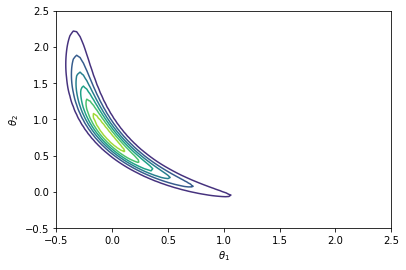

In [66]:
Ngrid = 100
x = np.linspace(-0.5, 2.5, Ngrid)
y = np.linspace(-0.5, 2.5, Ngrid)
X, Y = np.meshgrid(x, y)

Z = log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,X.flatten(),Y.flatten())
Z = np.exp(Z.reshape(Ngrid,Ngrid))


fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
plt.show()

#### Definition of the objective function:

In [67]:
def grad_x_log_target(x):
  out = grad_x_log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,x[0,:],x[1,:])
  return out

def log_target(x):
  out = log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,x[0,:],x[1,:])
  return out

def obj(coeffs, tri_map,x):
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)
    map_of_x = tri_map.Evaluate(x)
    rho_of_map_of_x = log_target(map_of_x)
    log_det = tri_map.LogDeterminant(x)
    return -np.sum(rho_of_map_of_x + log_det)/num_points

def grad_obj(coeffs, tri_map, x):
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)
    map_of_x = tri_map.Evaluate(x)
    sensi = grad_x_log_target(map_of_x)
    grad_rho_of_map_of_x = tri_map.CoeffGrad(x, sensi) 
    grad_log_det = tri_map.LogDeterminantCoeffGrad(x)
    return -np.sum(grad_rho_of_map_of_x + grad_log_det, 1)/num_points

In [68]:
#Draw reference samples
N=5000
Xtrain = np.random.randn(2,N)

#### Map parametrization and optimization:

In [69]:
# Set-up map and initize map coefficients
opts = MapOptions()

map_order = 3
tri_map = CreateTriangular(2,2,map_order,opts)
coeffs = np.zeros(tri_map.numCoeffs)
tri_map.SetCoeffs(coeffs)

options={'gtol': 1e-2, 'disp': True}
res = scipy.optimize.minimize(obj, tri_map.CoeffMap(), args=(tri_map, Xtrain), jac=grad_obj, method='BFGS', options=options)


Optimization terminated successfully.
         Current function value: -6.231009
         Iterations: 27
         Function evaluations: 31
         Gradient evaluations: 31


#### Comparing contours of approximate posterior and true unnormalized posterior

In [70]:
def push_forward_pdf(tri_map,rho,x):
  xinv = tri_map.Inverse(x,x)
  log_det_grad_x_inverse = - tri_map.LogDeterminant(xinv)
  log_pdf = rho.logpdf(xinv.T)+log_det_grad_x_inverse
  return np.exp(log_pdf)

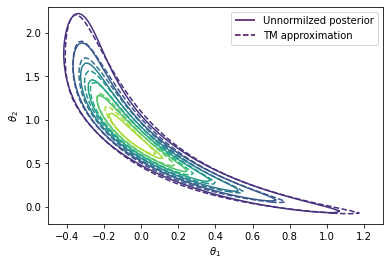

In [71]:
Ngrid = 100
x = np.linspace(-0.5, 1.3, Ngrid)
y = np.linspace(-0.2, 2.3, Ngrid)
xx, yy = np.meshgrid(x, y)

xx_eval = np.vstack((xx.flatten(),yy.flatten()))
Z2 = push_forward_pdf(tri_map,rho,xx_eval)
Z2 = Z2.reshape(Ngrid,Ngrid)

Z = log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,xx.flatten(),yy.flatten())
Z = np.exp(Z.reshape(Ngrid,Ngrid))

fig, ax = plt.subplots()
CS1 = ax.contour(xx, yy, Z)
CS2 = ax.contour(xx, yy, Z2,linestyles='dashed')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
h1,_ = CS1.legend_elements()
h2,_ = CS2.legend_elements()
ax.legend([h1[0], h2[0]], ['Unnormilzed posterior', 'TM approximation'])
plt.show()

### Drawing samples from approximate posterior

Once the transport map from reference to unnormalized posterior is estimated it can be used to sample from the posterior to characterize the Bayesian inference solution. 

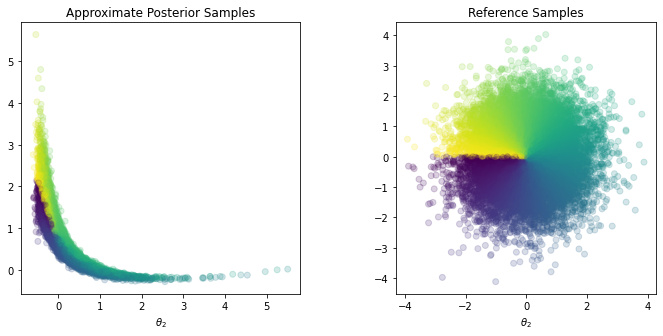

In [72]:
Znew = np.random.randn(2,15000)
colors = np.arctan2(Znew[1,:],Znew[0,:])

Xpost = tri_map.Evaluate(Znew)

fig,axs = plt.subplots(ncols=2,figsize=(12,5))
axs[0].scatter(Xpost[0,:],Xpost[1,:], c=colors, alpha=0.2)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlabel(r'$\theta_1$')
axs[0].set_ylabel(r'$\theta_2$')
axs[0].set_title('Approximate Posterior Samples')

axs[1].scatter(Znew[0,:],Znew[1,:], c=colors, alpha=0.2)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlabel(r'$\theta_1$')
axs[1].set_ylabel(r'$\theta_2$')
axs[1].set_title('Reference Samples')


plt.show()

Posterior mean:

In [73]:
X_mean = np.mean(Xpost,1)
print('Mean a posteriori: '+str(X_mean))

Mean a posteriori: [0.0461582  0.90654632]


One-dimensional marginals histograms:

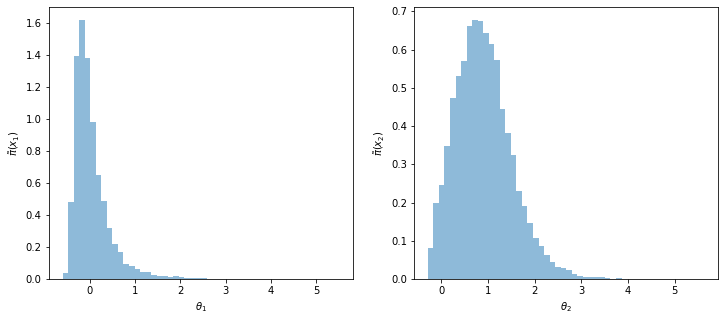

In [83]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].hist(Xpost[0,:], 50, alpha=0.5, density=True)
ax[0].set_xlabel(r'$\theta_1$')
ax[0].set_ylabel(r'$\tilde{\pi}(x_1)$')
ax[1].hist(Xpost[1,:], 50, alpha=0.5, density=True)
ax[1].set_xlabel(r'$\theta_2$')
ax[1].set_ylabel(r'$\tilde{\pi}(x_2)$')
plt.show()

## Part 4: Likelihood Free Inference

One other way to characterize the Bayesian inference solution is to use the property of triangular maps that allows characterization of conditional densities.

Indeed, let's consider two random vectors $\mathbf{x}$ and $\mathbf{y}$. If the triangular map $S$ with structure:
\begin{equation}
S=
\begin{bmatrix}
S_y(\mathbf{y})\\
S_x(\mathbf{y},\mathbf{x})
\end{bmatrix}
\end{equation}
is defined as:
\begin{equation}
\left[S^\sharp \eta\right](\mathbf{y},\mathbf{x}) = \pi(\mathbf{y},\mathbf{x}),
\end{equation}
then the conditional density $\pi(\mathbf{x}|\mathbf{y})$ can be defined with the lower block of $S$ as:
\begin{equation}
S_x(\mathbf{y},.)^\sharp \eta(\mathbf{x}) = \pi(\mathbf{x}|\mathbf{y})
\end{equation}

Applied to posterior characterization, this leads to computing the transport map between the joint density of observation and parameters $\pi(\mathbf{y},\boldsymbol{\theta})$ and reference density $\eta$.

### Generation of joint samples $\{\mathbf{y}^i,\boldsymbol{\theta}^i \}$

In [75]:
N = 10000
X = np.random.randn(2,N)

Y = np.zeros((5,N))

for t in range(5):
  Y[t,:]=forward_model(X[0,:],X[1,:],t+1)+std_noise*np.random.randn(1,N)

YX = np.vstack((Y,X))

### Normalization of samples

It is often beneficial to normalized training samples before computing a transport map. In order to that we simply define a linear map defined by mean and coviarance of training samples. 

In [76]:
mu = np.mean(YX,1)
std_data = np.std(YX,1)

Linv = np.diag(1/std_data)
mu_inv = - np.dot(Linv,mu)

YXnorm = mu_inv.reshape(-1,1)+np.dot(Linv,YX)

### Finding lower block map components

To characterize the posterior density from the map that characterizes the joint density, we actually only need to compute the map components corresponding to parameters. Hence in our Bayesian example, from the joint map of dimension 7 (5 observations + 2 parameters), we only need to compute the last two compoenents. Then, we can use the property of decomposability of the minimization problems to separately find map components 6 and 7.

In [77]:
# Negative log likelihood objective

rho1 = multivariate_normal(np.zeros(1),np.eye(1))
def obj(coeffs, tri_map,x):
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)
    map_of_x = tri_map.Evaluate(x)
    rho_of_map_of_x = rho1.logpdf(map_of_x.T)
    log_det = tri_map.LogDeterminant(x)
    return -np.sum(rho_of_map_of_x + log_det)/num_points

def grad_obj(coeffs, tri_map, x):
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)
    map_of_x = tri_map.Evaluate(x)
    grad_rho_of_map_of_x = -tri_map.CoeffGrad(x, map_of_x)
    grad_log_det = tri_map.LogDeterminantCoeffGrad(x)
    return -np.sum(grad_rho_of_map_of_x + grad_log_det, 1)/num_points

#### Component 6:

In [78]:
#multis6 = np.loadtxt('/content/multis6.txt',delimiter=',')
#mset6 = MultiIndexSet(multis6)
#fixed_mest6 = mset6.fix(True)

fixed_mset6 = FixedMultiIndexSet(6,4)

S6 = CreateComponent(fixed_mset6,opts)
Xtrain = YXnorm[:6,:]

options={'gtol': 1e-2, 'disp': True}
res2 = scipy.optimize.minimize(obj, S6.CoeffMap(), args=(S6, Xtrain), jac=grad_obj, method='BFGS', options=options)

Optimization terminated successfully.
         Current function value: 1.020512
         Iterations: 29
         Function evaluations: 33
         Gradient evaluations: 33


#### Component 7:

In [79]:
#multis7 = np.loadtxt('/content/multis7.txt',delimiter=',')
#mset7 = MultiIndexSet(multis7)
#fixed_mest7 = mset7.fix(True)

fixed_mset7 = FixedMultiIndexSet(7,3)

S7 = CreateComponent(fixed_mset7,opts)

Xtrain = YXnorm

options={'gtol': 1e-2, 'disp': True}
res2 = scipy.optimize.minimize(obj, S7.CoeffMap(), args=(S7, Xtrain), jac=grad_obj, method='BFGS', options=options)

Optimization terminated successfully.
         Current function value: -0.406756
         Iterations: 28
         Function evaluations: 31
         Gradient evaluations: 31


In [80]:
cond_map = TriangularMap((S6,S7))
cond_map.SetCoeffs(np.concatenate((S6.CoeffMap(),S7.CoeffMap())))

In [81]:
def cond_composed_pullback_pdf(tri_map,mu,L,rho,y,x):
  y = y.reshape(-1,1)*np.ones((len(y),x.shape[1]))
  yx = np.vstack((y,x))
  Lyx = mu.reshape(-1,1)+np.dot(L,yx)
  eval = tri_map.Evaluate(Lyx)
  log_pdf = rho.logpdf(eval.T)+tri_map.LogDeterminant(yx)+np.log(np.linalg.det(Linv))
  return np.exp(log_pdf)

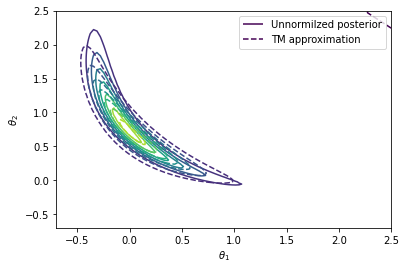

In [82]:
Ngrid = 100
x = np.linspace(-0.7, 2.5, Ngrid)
y = np.linspace(-0.7, 2.5, Ngrid)
xx, yy = np.meshgrid(x, y)

xx_eval = np.vstack((xx.flatten(),yy.flatten()))
Z2 = cond_composed_pullback_pdf(cond_map,mu_inv,Linv,rho,list_yobs,xx_eval)
Z2 = Z2.reshape(Ngrid,Ngrid)

Z = log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,xx.flatten(),yy.flatten())
Z = np.exp(Z.reshape(Ngrid,Ngrid))

fig, ax = plt.subplots()
CS1 = ax.contour(xx, yy, Z)
CS2 = ax.contour(xx, yy, Z2,linestyles='dashed')
h1,_ = CS1.legend_elements()
h2,_ = CS2.legend_elements()
ax.legend([h1[0], h2[0]], ['Unnormilzed posterior', 'TM approximation'])
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
plt.show()

Advantages of this method is that we don't need to explicity know the model, the likelihood function its derivates etc. The likelihood function is implicitly learned directly from samples. One drawback though is that map components are higher dimensional than in the map from density case.